In [1]:
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# 5 Cases of Touchard Recurrences

### Linear Case
$$
\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v).
$$

In [2]:
def deg_1_array(a_min,a_max,seq_length):
    a_len = a_max+1 - a_min
    
    a_range = np.arange(a_min, a_max+1)
    u_range = np.arange(seq_length)
    
    au_array = np.multiply.outer(a_range,u_range)
    
    return au_array

def deg_1_sqnc(a_min,a_max,seq_length,x=1,y=-1):
    a_len = a_max+1 - a_min
    
    coeff_array = deg_1_array(a_min,a_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,seq_length)).copy()
    
    for n in range(2,seq_length):
        vec_A = coeff_array[:,1:n]*seq_array[:,1:n]
        vec_B = seq_array[:,n-1:0:-1]
        seq_array[:,n] = (1/(n*(x*n+y)))*np.sum(vec_A*vec_B, axis=1)
    
    return seq_array

def deg_1_case(a,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u)*seq[u]*seq[v]
        if x*n+y == 0:
            seq[n] = np.nan
        else:
            seq[n] = Fraction(1,n*(x*n+y))*seq_sum
    return seq

In [3]:
def deg_1_fraction_cases(a,seq_length,x_min=1,x_max=1,y_min=-1,y_max=-1):
    x_len = x_max+1 - x_min
    y_len = y_max+1 - y_min
    
    seq_range = np.arange(seq_length)
    
    x_range = np.arange(x_min,x_max+1)
    y_range = np.arange(y_min,y_max+1)
    
    xn_squared_array = np.multiply.outer(x_range,seq_range**2)
    xn_squared_tensor = np.broadcast_to(xn_squared_array, (y_len,x_len,seq_length))
    
    yn_array = np.multiply.outer(y_range,seq_range)
    yn_tensor = np.broadcast_to(yn_array,(x_len,y_len,seq_length))
    
    corrected_xn_tensor = np.swapaxes(xn_squared_tensor,0,1)
    
    xn_yn_array = corrected_xn_tensor + yn_tensor
    
    one_array = np.full((x_len,y_len,seq_length),1,dtype=np.float)
    
    frac_array = np.divide(one_array,xn_yn_array, out=np.full_like(one_array,np.nan), where=xn_yn_array!=0)
    
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq,(x_len,y_len,seq_length)).copy()

    coeffs = a*seq_range

    for n in range(2,seq_length):
        fracs = frac_array[:,:,n]
        vec_A = coeffs[1:n]*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = fracs*np.sum(vec_A*vec_B,axis=2)
    
    return seq_array

### Quadratic Case
$$
\tau(n) = \frac{1}{n^2(n-1)}\sum_{u+v=n}(au^2+buv)\tau(u)\tau(v)
$$
$\sigma(n)$ is at $(a,b) = (-24,36)$.

In [4]:
def deg_2_array(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_squared_matrix = np.multiply.outer(a_range, u_range*u_range) # a x u
    au_tensor = np.broadcast_to(au_squared_matrix,(seq_length,b_len,a_len,seq_length)) # k x b x a x k
    #k,b,a,k --> a,b,k,k
    
    bu_matrix = np.multiply.outer(b_range,u_range) # b_len x seq_length
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b_len x seq_len x seq_len
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,b_len,seq_length,seq_length))
    
    corrected_au_tensor = np.swapaxes(au_tensor, 0,2)
    #corrected_buv_tensor = np.swapaxes(buv_tensor, 2,3)
    
    tensor = corrected_au_tensor + buv_tensor
    
    P_array = np.swapaxes(tensor, 2,3)
    
    return P_array


def deg_2_sqnc(a_min,a_max,b_min,b_max,seq_length,x=1,y=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_2_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**2)*(x*n+y)))*np.sum(vec_A*vec_B,axis=2)
    
    return seq_array


def deg_2_case(a,b,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u*u+b*u*v)*seq[u]*seq[v]
        if x*n+y == 0:
            seq[n] = seq_sum
        else:
            seq[n] = Fraction(1,n*n*(x*n+y))*seq_sum
    return seq

$\tau(n) = \frac{1}{n^2}\sum_{u+v=n}(au^2+auv)\tau(u)\tau(v)$ produces $(\frac{a}{2})^{n-1}\times C_n$. I guess this shouldn't be surprising since
$$
\frac{1}{n^2}\sum_{u+v=n}(au^2+auv)\tau(u)\tau(v) = \frac{1}{n^2}\sum_{u+v=n}(\frac{a}{2}u + \frac{a}{2}v)(u+v)\tau(u)\tau(v) = \sum_{u+v}\frac{a}{2}\tau(u)\tau(v)
$$
by exploiting symmetry and skipping a bunch of steps.

### Cubic Case
$$
\tau(n) = \frac{1}{n^3(n-1)}\sum_{u+v=n}(au^3+bu^2v)\tau(u)\tau(v)
$$
$\sigma(n)$ is at $(-24,48)$.

In [5]:
def deg_3_array(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_squared_matrix = np.multiply.outer(a_range, u_range*u_range*u_range) # a x u^3
    au_tensor = np.broadcast_to(au_squared_matrix,(seq_length,b_len,a_len,seq_length)) # k x b x a x k
    #k,b,a,k --> a,b,k,k
    
    bu_matrix = np.multiply.outer(b_range,u_range*u_range) # b x u^2
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^2 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,b_len,seq_length,seq_length)) # a x b x k x k
    
    corrected_au_tensor = np.swapaxes(au_tensor, 0,2)
    #corrected_buv_tensor = np.swapaxes(buv_tensor, 2,3)
    
    tensor = corrected_au_tensor + buv_tensor
    
    P_array = np.swapaxes(tensor, 2,3)
    
    return P_array


def deg_3_sqnc(a_min,a_max,b_min,b_max,seq_length,x=1,y=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_3_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**3)*(x*n + y)))*np.sum(vec_A*vec_B,axis=2)
    
    return seq_array

def deg_3_case(a,b,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u*u*u + b*u*u*v)*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**3)*(x*n + y)))*seq_sum
    
    return seq

### Quartic Case
$$
\tau(n) = \frac{1}{n^4(n-1)}\sum_{u+v=n}(au^4 + bu^3v + cu^2v^2)\tau(u)\tau(v).
$$
$\sigma(n)$ is at $(-24,24,48)$.

In [6]:
def deg_4_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    c_range = np.arange(c_min, c_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_matrix = np.multiply.outer(a_range, u_range**4) # a x u^4
    au_tensor = np.broadcast_to(au_matrix,(seq_length,b_len,c_len,a_len,seq_length)) # k x b x c x a x u^4
    #v,b,c,a,u --> a,b,c,v,u --> a,b,c,u,v
    
    bu_matrix = np.multiply.outer(b_range,u_range**3) # b x u^3
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^3 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,c_len,b_len,seq_length,seq_length)) # a x c x b x u^3 x v
    # a,c,b,u,v --> a,b,c,u,v
    
    cu_matrix = np.multiply.outer(c_range,u_range**2) # c x u^2
    cuv_matrix = np.multiply.outer(cu_matrix,v_range**2) # c x u^2 x v^2
    cuv_tensor = np.broadcast_to(cuv_matrix,(a_len,b_len,c_len,seq_length,seq_length)) # a x b x c x u^2 x v^2
    
    corrected_au_tensor = np.swapaxes(np.swapaxes(au_tensor, 3,4),0,4)
    corrected_buv_tensor = np.swapaxes(buv_tensor, 1,2)
    
    tensor = corrected_au_tensor + corrected_buv_tensor + cuv_tensor
    
    #P_array = np.swapaxes(tensor, 3,4)
    
    return tensor


def deg_4_sqnc(a_min,a_max,b_min,b_max,c_min,c_max,seq_length,x=1,y=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    coeff_array = deg_4_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,c_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 3, axis2 = 4)[:,:,:,1:n]
        vec_A = diag*seq_array[:,:,:,1:n]
        vec_B = seq_array[:,:,:,n-1:0:-1]
        seq_array[:,:,:,n] = (1/((n**4)*(x*n+y)))*np.sum(vec_A*vec_B,axis=3)
    
    return seq_array


def deg_4_case(a,b,c,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u**4 + b*(u**3)*v + c*(u**2)*(v**2))*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**4)*(x*n + y)))*seq_sum
    
    return seq

### Quintic Case
$$
\tau(n) = \frac{1}{n^5(n-1)}\sum_{u+v=n}(au^5+bu^4v+cu^3v^2)\tau(u)\tau(v).
$$
$\sigma(n)$ is at $(-24,0,120)$.

In [7]:
def deg_5_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    c_range = np.arange(c_min, c_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_matrix = np.multiply.outer(a_range, u_range**5) # a x u^5
    au_tensor = np.broadcast_to(au_matrix,(seq_length,b_len,c_len,a_len,seq_length)) # k x b x c x a x u^4
    #v,b,c,a,u --> a,b,c,v,u --> a,b,c,u,v
    
    bu_matrix = np.multiply.outer(b_range,u_range**4) # b x u^4
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^4 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,c_len,b_len,seq_length,seq_length)) # a x c x b x u^3 x v
    # a,c,b,u,v --> a,b,c,u,v
    
    cu_matrix = np.multiply.outer(c_range,u_range**3) # c x u^3
    cuv_matrix = np.multiply.outer(cu_matrix,v_range**2) # c x u^3 x v^2
    cuv_tensor = np.broadcast_to(cuv_matrix,(a_len,b_len,c_len,seq_length,seq_length)) # a x b x c x u^3 x v^2
    
    corrected_au_tensor = np.swapaxes(np.swapaxes(au_tensor, 3,4),0,4)
    corrected_buv_tensor = np.swapaxes(buv_tensor, 1,2)
    
    tensor = corrected_au_tensor + corrected_buv_tensor + cuv_tensor
    
    #P_array = np.swapaxes(tensor, 3,4)
    
    return tensor


def deg_5_sqnc(a_min,a_max,b_min,b_max,c_min,c_max,seq_length,x=1,y=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    coeff_array = deg_5_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,c_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 3, axis2 = 4)[:,:,:,1:n]
        vec_A = diag*seq_array[:,:,:,1:n]
        vec_B = seq_array[:,:,:,n-1:0:-1]
        seq_array[:,:,:,n] = (1/((n**5)*(x*n+y)))*np.sum(vec_A*vec_B,axis=3)
    
    return seq_array


def deg_5_case(a,b,c,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u**5 + b*(u**4)*v + c*(u**3)*(v**2))*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**5)*(x*n + y)))*seq_sum
    
    return seq

## Catalan Numbers
$$
C_n = \sum_{u+v=n}C_uC_v
$$

In [8]:
def catalan(length):
    catlist = np.zeros(length)
    catlist[1] = 1
    for n in range(2,length):
        vec_A = catlist[1:n]
        vec_B = catlist[n-1:0:-1]
        catlist[n] = np.dot(vec_A,vec_B)

    return catlist

In [9]:
catalan(21)

array([0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.00000000e+00,
       5.00000000e+00, 1.40000000e+01, 4.20000000e+01, 1.32000000e+02,
       4.29000000e+02, 1.43000000e+03, 4.86200000e+03, 1.67960000e+04,
       5.87860000e+04, 2.08012000e+05, 7.42900000e+05, 2.67444000e+06,
       9.69484500e+06, 3.53576700e+07, 1.29644790e+08, 4.77638700e+08,
       1.76726319e+09])

# Geometric Sequence Checker

In [9]:
def array_div(A): # input is 3d array
    if len(A.shape) == 2:
        orig_sqnc_len = A.shape[1]
        
        shift_1 = A[:,2::]
        shift_2 = A[:,1:-1]
        
        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        
        return div_array
    
    elif len(A.shape) == 3:
        orig_sqnc_len = A.shape[2]

        shift_1 = A[:,:,2::] # starts each sequence at their second index
        shift_2 = A[:,:,1:-1] # then at their first index

        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        # puts a zero wherever it had to divide by zero

        return div_array
    
    elif len(A.shape) == 4:
        orig_sqnc_len = A.shape[3]
        
        shift_1 = A[:,:,:,2::]
        shift_2 = A[:,:,:,1:-1]
        
        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        
        return div_array

In [10]:
def geom_sqnc_check(A,a_min=0,b_min=0,c_min=0): # need those extra inputs to get the a and b values correct in the tuples
    np.seterr(all="ignore")
   
    quot_array = array_div(A)
    
    if len(A.shape) == 2:
        bool_array = (np.abs(quot_array[:,:-1] - quot_array[:,1:]) < 1e-5).sum(axis=1) == (quot_array.shape[1]-1)
        
        a_coords = np.where(bool_array)[0]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,a_coords[n]) for n in range(length)]
        
        return coord_list
    
    elif len(A.shape) == 3:
        bool_array = (np.abs(quot_array[:,:,:-1] - quot_array[:,:,1:]) < 1e-5).sum(axis=2) == (quot_array.shape[2]-1)

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,a_coords[n],b_coords[n]) for n in range(length)]
        # I wanted to include the indices as well so it's easier to find in the array

        return coord_list
    
    elif len(A.shape) == 4:
        bool_array = (np.abs(quot_array[:,:,:,:-1] - quot_array[:,:,:,1:]) < 1e-5).sum(axis=3) == (quot_array.shape[3]-1)
        
        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        c_coords = arrays[2]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,c_coords[n]+c_min) for n in range(length)]
        # Just letting the tuple be (a,b,c) or else it'll get really cluttered
        
        return coord_list #implement scatter plot

# Integer Sequence Checker

In [11]:
def int_sqnc_check(A,a_min=0,b_min=0,c_min=0):
    np.seterr(all="ignore")
    if len(A.shape) == 2:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=1) >= (A.shape[1]-1)

        a_coords = np.where(bool_array)[0]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,a_coords[n]) for n in range(length)]

        return coord_list
    
    elif len(A.shape) == 3:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=2) >= (A.shape[2]-1)

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,a_coords[n],b_coords[n]) for n in range(length)]

        return coord_list
    
    elif len(A.shape) == 4:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=3) >= (A.shape[3]-1)

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        c_coords = arrays[2]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,c_coords[n]+c_min) for n in range(length)]

        return coord_list

In [12]:
def zero_sqnc_check(A,a_min=0,b_min=0,c_min=0):
    if len(A.shape) == 2:
        bool_array = A[:,2:].sum(axis=1) == 0
        
        a_coords = np.where(bool_array)[0]
        length = len(a_coords)
        coord_list = [(a_coords[n]+ a_min,a_coords[n]) for n in range(length)]
        
        return coord_list
    
    elif len(A.shape) == 3:
        bool_array = A[:,:,2:].sum(axis=2) == 0
            
        a_coords = np.where(bool_array)[0]
        b_coords = np.where(bool_array)[1]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,a_coords[n],b_coords[n]) for n in range(length)]
        
        return coord_list
    
    elif len(A.shape) == 4:
        bool_array = A[:,:,:,2:].sum(axis=3) == 0
        
        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        c_coords = arrays[2]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,c_coords[n]+c_min) for n in range(length)]

        return coord_list

# A Fun Alteration

Below is an alteration to that term of the function. We use these to check for some possible interesting sequences of integers.

In [20]:
def weird_deg_2(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_2_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**2)*(n-1)*(n+1)))*np.sum(vec_A*vec_B,axis=2)

    return seq_array

In [169]:
B[2,2]

array([ 0.00000000e+00,  1.00000000e+00, -8.00000000e+00,  4.80000000e+01,
       -2.56000000e+02,  1.28000000e+03, -6.14400000e+03,  2.86720000e+04,
       -1.31072000e+05,  5.89824000e+05, -2.62144000e+06,  1.15343360e+07,
       -5.03316480e+07,  2.18103808e+08, -9.39524096e+08,  4.02653184e+09,
       -1.71798692e+10,  7.30144440e+10, -3.09237645e+11,  1.30567006e+12,
       -5.49755814e+12])

Alright! So, to start off, we have an interesting sequence where $a = -48$ and $b = -48$. We get:
$$
\{\tau(n)\} = \{1,-8,48,-256,1280,6144,...\}
$$

In [170]:
B[74,74]

array([0.000000e+00, 1.000000e+00, 4.000000e+00, 1.200000e+01,
       3.200000e+01, 8.000000e+01, 1.920000e+02, 4.480000e+02,
       1.024000e+03, 2.304000e+03, 5.120000e+03, 1.126400e+04,
       2.457600e+04, 5.324800e+04, 1.146880e+05, 2.457600e+05,
       5.242880e+05, 1.114112e+06, 2.359296e+06, 4.980736e+06,
       1.048576e+07])

Another one for $(24,24)$:
$$
\{\tau(n)\} = \{1,4,12,32,80,192,448,...\}
$$
which should be a familiar sequence:
$$
\{\tau(n)\} = \{n2^{n-1}\}
$$

In [171]:
B[62,62]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

This just gives us the natural numbers. Maybe we have $\{\tau(n)\} = \{n1^{n-1}\}$.

In [172]:
B[86,86]

array([0.00000000e+00, 1.00000000e+00, 6.00000000e+00, 2.70000000e+01,
       1.08000000e+02, 4.05000000e+02, 1.45800000e+03, 5.10300000e+03,
       1.74960000e+04, 5.90490000e+04, 1.96830000e+05, 6.49539000e+05,
       2.12576400e+06, 6.90873300e+06, 2.23205220e+07, 7.17445350e+07,
       2.29582512e+08, 7.31794257e+08, 2.32452293e+09, 7.36098929e+09,
       2.32452293e+10])

$(36,36)$ gives $\{\tau(n)\} = \{n3^{n-1}\}.$

__Idea__: Let $\tau(n) = \frac{1}{n^2(n-1)(n+1)}\sum_{u+v=n}(au^2 +buv)\tau(u)\tau(v)$ be the $n^{th}$ term in a sequence. If $(a,b) = (12k,12k)$ for $k \in \mathbb{Z}$, then $\{\tau(n)\} = \{nk^{n-1}\}.$

# Some Graphs

It's worth noting the pairs $(a,b)$ that give us sequences of zeros. When we have $(a,b) = (a,-a)$, and we define our sequence by
$$
\tau(n) = \frac{1}{n^p(xn+y)}\sum_{u+v=n}(au^2+buv)\tau(u)\tau(v),
$$
with our first term $\tau(1) = 1$, we find that
$$
\tau(2) = (a(1^2) - a(1)(1))\tau(1)\tau(1) = a-a = 0.
$$
Then, since every following term calls on $\tau(k)$ with $k \geq 2$, every term must be 0. Therefore, any quadratic/cubic touchard recurrence with $(a,b) = (a,-a)$ must produce a sequence of the form $\{1,0,0,0,\dots\}$. This can be extended to higher-degree cases as well.

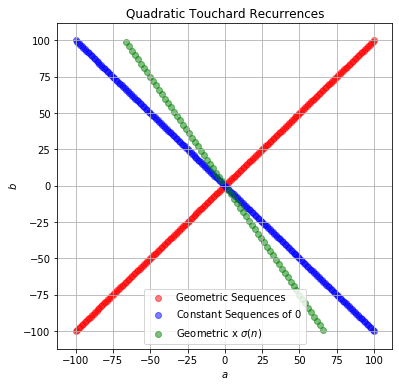

In [14]:
A = deg_2_sqnc(-100,100,-100,100,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-100,-100)
combo_coords = geom_sqnc_check(combo,-100,-100)
zero_coords = zero_sqnc_check(A,-100,-100)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]

zeroa_coords = [coords[0] for coords in zero_coords]
zerob_coords = [coords[1] for coords in zero_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]

plt.figure(figsize = (6,6))
plt.scatter(geoma_coords,geomb_coords, c = 'red', alpha=.5, label = 'Geometric Sequences')
plt.scatter(zeroa_coords,zerob_coords, c = 'blue', alpha=.5, label = 'Constant Sequences of $0$')
plt.scatter(comboa_coords,combob_coords, c = 'green', alpha=.5, label = 'Geometric x $\sigma(n)$')
plt.title('Quadratic Touchard Recurrences')
plt.grid()
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.legend()
plt.show()

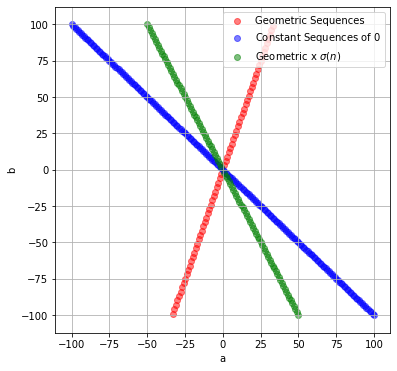

In [15]:
A = deg_3_sqnc(-100,100,-100,100,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-100,-100)
zero_coords = zero_sqnc_check(A,-100,-100)
combo_coords = geom_sqnc_check(combo,-100,-100)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]

zeroa_coords = [coords[0] for coords in zero_coords]
zerob_coords = [coords[1] for coords in zero_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]

plt.figure(figsize = (6,6))
plt.scatter(geoma_coords,geomb_coords, c = 'red', alpha=.5, label = 'Geometric Sequences')
plt.scatter(zeroa_coords,zerob_coords, c = 'blue', alpha=.5, label = 'Constant Sequences of $0$')
plt.scatter(comboa_coords,combob_coords, c = 'green', alpha=.5, label = 'Geometric x $\sigma(n)$')
plt.grid()
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


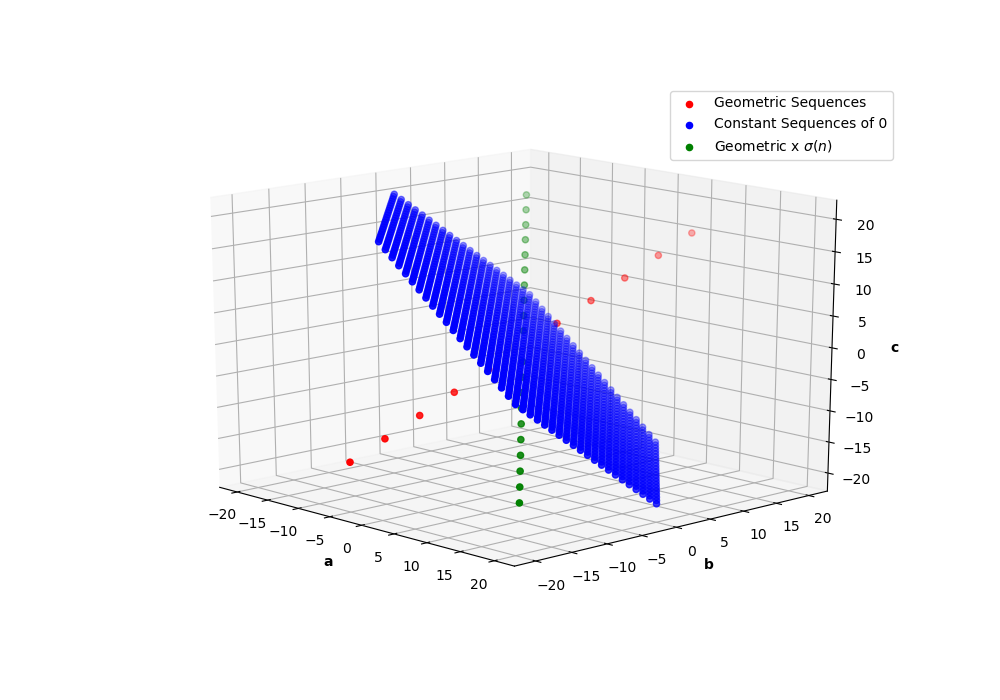

In [19]:
%matplotlib notebook

A = deg_4_sqnc(-20,20,-20,20,-20,20,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-20,-20,-20)
zero_coords = zero_sqnc_check(A,-20,-20,-20)
combo_coords = geom_sqnc_check(combo,-20,-20,-20)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]
geomc_coords = [coords[2] for coords in geom_coords]

zeroa_coords = [coords[0] for coords in zero_coords]
zerob_coords = [coords[1] for coords in zero_coords]
zeroc_coords = [coords[2] for coords in zero_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]
comboc_coords = [coords[2] for coords in combo_coords]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(geoma_coords,geomb_coords,geomc_coords, c = 'red', label = 'Geometric Sequences') # geometric sequences
ax.scatter(zeroa_coords,zerob_coords,zeroc_coords, c = 'blue', label = 'Constant Sequences of 0') # integer sequences sequences
ax.scatter(comboa_coords,combob_coords,comboc_coords, c = 'green', label = 'Geometric x $\sigma(n)$') # combo sequences
ax.set_xlabel('a', fontweight ='bold')
ax.set_ylabel('b', fontweight ='bold')
ax.set_zlabel('c', fontweight ='bold')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


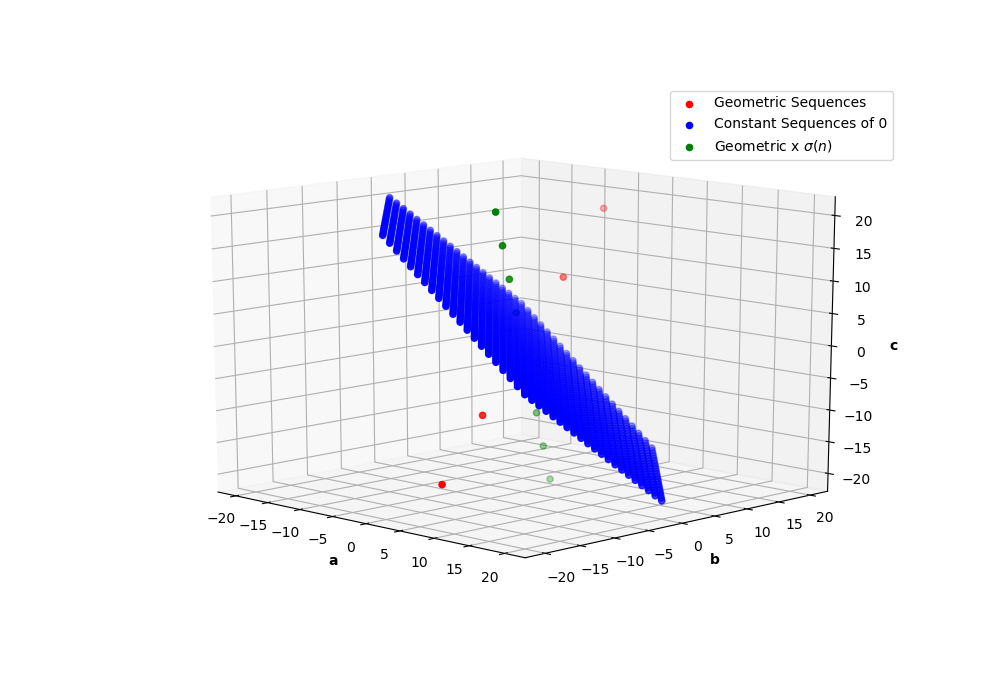

In [27]:
A = deg_5_sqnc(-20,20,-20,20,-20,20,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-20,-20,-20)
zero_coords = zero_sqnc_check(A,-20,-20,-20)
combo_coords = geom_sqnc_check(combo,-20,-20,-20)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]
geomc_coords = [coords[2] for coords in geom_coords]

zeroa_coords = [coords[0] for coords in zero_coords]
zerob_coords = [coords[1] for coords in zero_coords]
zeroc_coords = [coords[2] for coords in zero_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]
comboc_coords = [coords[2] for coords in combo_coords]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(geoma_coords,geomb_coords,geomc_coords, c = 'red', label = 'Geometric Sequences') # geometric sequences
ax.scatter(zeroa_coords,zerob_coords,zeroc_coords, c = 'blue', label = 'Constant Sequences of 0') # integer sequences sequences
ax.scatter(comboa_coords,combob_coords,comboc_coords, c = 'green', label = 'Geometric x $\sigma(n)$') # combo sequences
ax.set_xlabel('a', fontweight ='bold')
ax.set_ylabel('b', fontweight ='bold')
ax.set_zlabel('c', fontweight ='bold')
ax.legend()
plt.show()

In [305]:
combo_coords

[(-4, 0, 20),
 (-3, 0, 15),
 (-2, 0, 10),
 (-1, 0, 5),
 (1, 0, -5),
 (2, 0, -10),
 (3, 0, -15),
 (4, 0, -20)]

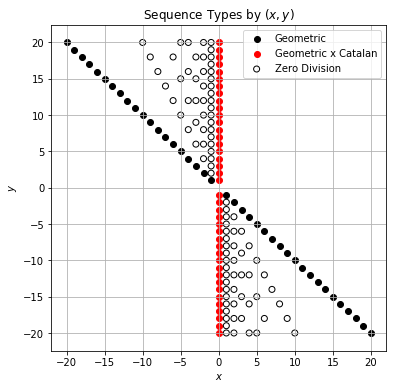

In [16]:
divzero_list = []
reflected = []
for x in range(1,21):
    for y in range(1,21):
        if y > x and y%x==0:
            divzero_list.append((-x,y))
            reflected.append((x,-y))
            
zerodiv = reflected + divzero_list # precisely where xn + y = 0


test = deg_1_fraction_cases(1,40,-20,20,-20,20)
geom_coords = geom_sqnc_check(test,-20,-20)
cat = catalan(40)
cat_test = test/cat
cat_coords = geom_sqnc_check(cat_test,-20,-20)
            
xgeom_coords = [coord[0] for coord in geom_coords]
ygeom_coords = [coord[1] for coord in geom_coords]

xcat_coords = [coord[0] for coord in cat_coords]
ycat_coords = [coord[1] for coord in cat_coords]

xzerodiv = [coord[0] for coord in zerodiv]
yzerodiv = [coord[1] for coord in zerodiv]

plt.figure(figsize = (6,6))
plt.scatter(xgeom_coords,ygeom_coords, c = 'black', label = 'Geometric')
plt.scatter(xcat_coords,ycat_coords, c = 'red', label = 'Geometric x Catalan')
plt.scatter(xzerodiv,yzerodiv, facecolors = 'none', edgecolors = 'black', label = 'Zero Division')
plt.title('Sequence Types by $(x,y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.legend()
plt.show()

## A Proof

We notice that every sequence produced by the linear case seems to produce a geometric sequence. We first prove this, and then use that fact to show that we get a geometric sequence from the quadratic case if $(a,b) = (a,a)$. By multiplying $\tau(n)$ iteratively by $\frac{n}{n}$, we can determine at least one branch of geometric sequences for any higher-order case, but I'll show this for the quadratic case.

Let $\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v)$. With the prior defined function, we notice a pattern than $\tau(n) = \left(\frac{a}{2}\right)^{n-1}$.

In [27]:
deg_1_case(3,10)

[0,
 Fraction(1, 1),
 Fraction(3, 2),
 Fraction(9, 4),
 Fraction(27, 8),
 Fraction(81, 16),
 Fraction(243, 32),
 Fraction(729, 64),
 Fraction(2187, 128),
 Fraction(6561, 256)]

We use strong induction.

As per the definition of the sequence, $\tau(1) = 1$, and $1 = \frac{a^{1-1}}{2^{1-1}}$. Therefore the base case holds.

Suppose $\tau(k) = \left(\frac{a}{2}\right)^{n-1}$ for every $k \in \mathbb{N}$ with $1 \leq k \leq n$. We want to show that $\tau(n+1) = \left(\frac{a}{2}\right)^n$. In particular, we can show that $\tau(n+1) = \frac{a}{2}\tau(n)$, or $\frac{\tau(n+1)}{\tau(n)} = \frac{a}{2}$.
$$
\frac{\tau(n+1)}{\tau(n)} = \frac{\frac{1}{n(n+1)}\sum_{u+v=n+1}au\tau(u)\tau(v)}{\tau(n)} = \frac{\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)}{\frac{a^{n-1}}{2^{n-1}}} = \frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)
$$
We consider the individual terms of $\sum_{u+v=n+1}u\tau(u)\tau(v)$, noting that each $k \leq n$ term holds.
$$
\sum_{u+v=n+1}au\tau(u)\tau(v)
$$
$$
= a\tau(1)\tau(n) + 2a\tau(2)\tau(n-1) + 3a\tau(3)\tau(n-2) + \cdots + na\tau(n)\tau(1)
$$
$$
= \left(a\frac{a^{n-1}}{2^{n-1}}\right) + \left(2a\frac{a}{2}\frac{a^{n-2}}{2^{n-2}}\right) + \left(3a\frac{a^2}{4}\frac{a^{n-3}}{2^{n-3}}\right)\cdots + \left(na\frac{a^{n-1}}{2^{n-1}}\right)
$$
$$
= a\frac{a^{n-1}}{2^{n-1}} + 2a\frac{a^{n-1}}{2^{n-1}} + 3a\frac{a^{n-1}}{2^{n-1}} + \cdots + na\frac{a^{n-1}}{2^{n-1}}.
$$
Then
$$
\frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)
$$
$$
= \frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\left(a\frac{a^{n-1}}{2^{n-1}}+ 2a\frac{a^{n-1}}{2^{n-1}} + 3a\frac{a^{n-1}}{2^{n-1}} + \cdots + na\frac{a^{n-1}}{2^{n-1}}\right)
$$
$$
= \frac{1}{n(n-1)}(a + 2a + 3a + \cdots + na)
$$
$$
= \frac{a}{n(n+1)}(1 + 2 + 3 + \cdots + n)
$$
$$
\frac{a}{n(n+1)}\sum_{k=1}^nk
$$
$$
\frac{a}{n(n+1)}\frac{n(n+1)}{2} = \frac{a}{2},
$$
Hence $\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v) = \left(\frac{a}{2}\right)^{n-1}$ for all $n \in \mathbb{N}$.

Furthermore, since $u+v=n$, we have
$$
\left(\frac{a}{2}\right)^{n-1} = \tau(n) = \frac{n}{n}\tau(n) = \frac{n}{n}\frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v)
$$
$$
= \frac{1}{n^2(n-1)}\sum_{u+v=n}aun\tau(u)\tau(v) = \frac{1}{n^2(n-1)}\sum_{u+v=n}au(u+v)\tau(u)\tau(v)
$$
$$
= \frac{1}{n^2(n-1)}\sum_{u+v=n}(au^2+auv)\tau(u)\tau(v),
$$
thus giving us a branch of geometric sequences for the quadratic case.

By iterating this process of multiplying the sequence by $\frac{n}{n}$, we maintain the geometric sequence while increasing the degree of the polynomial in the sum, thus giving us at least one branch of geometric sequences for every degree $\geq 2$.

## Wild Sequences

"$\tau(n)$ is <u>wild</u> if the set of prime numbers dividing the denominators in the sequence $\tau(n)$ is infinite. In particular, there does not exist a positive integer $N \in \mathbb{Z}$ such that, for all $n \geq 1$, $\tau(n)\cdot N^n \in \mathbb{Z}$."

The hope is that everything $(a,b) \neq (a,a), (a,-a)$, or $(-2k,3k)$, $k \in \mathbb{Z}$ is wild.

Below are functions that will assist in finding the prime factors of the denominators in those off-branch sequences.

In [17]:
from math import sqrt
def isprime_list(n):

    flags = [True] * (n+1)
    flags[0] = False
    flags[1] = False
    flags[4::2] = [False] * ((n-2)//2)
    p = 3
    while p <= sqrt(n):
        if flags[p]:
            flags[p*p::2*p] = [False] * ((n-p*p)//(2*p)+1)
        p = p + 2
        
    return flags

def where(L):
    return [n for n in range(len(L)) if L[n]]

In [18]:
def denom_prime_factor_check(L,index): # fraction, int
    test = L[index-1].denominator
    primes = where(isprime_list(index))
    factors = ()
    for p in primes[2:]:
        if test % p == 0:
            factors += (str(p),)
    string = ', '.join(factors)
    return string

In [42]:
a_choices = list(range(1,20))
b_choices = list(range(1,20))

a_list = np.random.choice(a_choices,20)
b_list = np.random.choice(b_choices,20)

tup_list = [(a_list[n],b_list[n]) for n in range(20)]

n=0
for tup in tup_list:
    test = deg_2_case(tup[0],tup[1],50) # checking the 50th sequence entry.
    print('\hline', tup, '&', denom_prime_factor_check(test,50), '\\\\')
    # Printed such that I can copy and paste into LaTeX nicely

\hline (1, 13) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (9, 5) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (14, 9) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (17, 16) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (8, 8) &  \\
\hline (11, 11) &  \\
\hline (14, 11) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (14, 17) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (7, 10) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (8, 1) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (5, 2) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (9, 11) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (7, 12) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (19, 16) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (8, 8) &  \\
\hline (9, 6) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (14, 6) & 5, 7, 11, 13, 17, 19, 23, 29, 

In [46]:
a_choices = list(range(1,20,2))
b_choices = list(range(2,20,2))
# going with (+odd,+even)

a_list = np.random.choice(a_choices,20)
b_list = np.random.choice(b_choices,20)

tup_list = [(a_list[n],b_list[n]) for n in range(20)]

n=0
for tup in tup_list:
    test = deg_2_case(tup[0],tup[1],50) # checking the 50th sequence entry.
    print('\hline'  ,tup, '&', denom_prime_factor_check(test,50), '\\\\') # (a,b), prime factor tuple

\hline (7, 14) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (13, 10) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (15, 18) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (15, 10) & 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (7, 2) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (15, 12) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (5, 10) & 11, 17, 23, 29, 41, 47 \\
\hline (9, 2) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (15, 10) & 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (13, 18) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (5, 14) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (7, 12) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (1, 16) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (19, 18) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (15, 10) & 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (3, 18) & 5, 7, 

In [47]:
tup_list[0]

(7, 14)

In [48]:
tup_list[6]

(5, 10)

The denominators for $(7,14)$ and $(5,10)$ have less prime factors. Something weird is happening with the prime divisors of these. I'll run the code again, but only for inputs $(a,2a)$ up to like $(20,40)$.

In [49]:
a_choices = list(range(1,21))
b_choices = list(range(2,42,2))

tup_list = [(a_choices[n],b_choices[n]) for n in range(20)]

n=0
for tup in tup_list:
    test = deg_2_case(tup[0],tup[1],40)
    print('\hline' ,tup, '&', denom_prime_factor_check(test,40), '\\\\') # prime factor tuple, index of coordinates
    n+=1

\hline (1, 2) & 5, 11, 17, 23, 29 \\
\hline (2, 4) & 5, 11, 17, 23, 29 \\
\hline (3, 6) & 5, 11, 17, 23, 29 \\
\hline (4, 8) & 5, 11, 17, 23, 29 \\
\hline (5, 10) & 11, 17, 23, 29 \\
\hline (6, 12) & 5, 11, 17, 23, 29 \\
\hline (7, 14) & 5, 11, 17, 23, 29 \\
\hline (8, 16) & 5, 11, 17, 23, 29 \\
\hline (9, 18) & 5, 11, 17, 23, 29 \\
\hline (10, 20) & 11, 17, 23, 29 \\
\hline (11, 22) & 5, 17, 23, 29 \\
\hline (12, 24) & 5, 11, 17, 23, 29 \\
\hline (13, 26) & 5, 11, 17, 23, 29 \\
\hline (14, 28) & 5, 11, 17, 23, 29 \\
\hline (15, 30) & 11, 17, 23, 29 \\
\hline (16, 32) & 5, 11, 17, 23, 29 \\
\hline (17, 34) & 5, 11, 23, 29 \\
\hline (18, 36) & 5, 11, 17, 23, 29 \\
\hline (19, 38) & 5, 11, 17, 23, 29 \\
\hline (20, 40) & 11, 17, 23, 29 \\


Well now.

50th term?

In [53]:
a_choices = list(range(1,31))
b_choices = list(range(2,62,2))

tup_list = [(a_choices[n],b_choices[n]) for n in range(30)]

n=0
for tup in tup_list:
    test = deg_2_case(tup[0],tup[1],50)
    print('\hline' ,tup, '&', denom_prime_factor_check(test,50), '\\\\') # prime factor tuple, index of coordinates
    n+=1

\hline (1, 2) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (2, 4) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (3, 6) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (4, 8) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (5, 10) & 11, 17, 23, 29, 41, 47 \\
\hline (6, 12) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (7, 14) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (8, 16) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (9, 18) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (10, 20) & 11, 17, 23, 29, 41, 47 \\
\hline (11, 22) & 5, 17, 23, 29, 41, 47 \\
\hline (12, 24) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (13, 26) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (14, 28) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (15, 30) & 11, 17, 23, 29, 41, 47 \\
\hline (16, 32) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (17, 34) & 5, 11, 23, 29, 41, 47 \\
\hline (18, 36) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (19, 38) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (20, 40) & 11, 17, 23, 29, 41, 47 \\
\hline (21, 42) & 5, 11, 17, 23, 29, 41, 47 \\
\hline (22, 44) & 5, 17, 23, 29, 41, 47 \\
\hl

In [62]:
a_choices = list(range(-1,-20,-1))
b_choices = list(range(1,20))

a_list = np.random.choice(a_choices,20)
b_list = np.random.choice(b_choices,20)

tup_list = [(a_list[n],b_list[n]) for n in range(20)]

n=0
for tup in tup_list:
    test = deg_2_case(tup[0],tup[1],50) # checking the 50th sequence entry.
    print('\hline', tup, '&', denom_prime_factor_check(test,50), '\\\\')

\hline (-13, 5) & 5, 7, 11, 13, 17, 19, 23, 29, 37, 41, 43, 47 \\
\hline (-10, 11) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-9, 1) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-10, 9) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-2, 12) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-19, 14) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-3, 8) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-9, 5) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-14, 10) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-16, 5) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-14, 8) & 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-11, 10) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-5, 2) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-2, 10) & 5, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47 \\
\hline (-12, 8) & 5, 7, 11, 13, 17, 19, 23, 29, 

In [36]:
def denom_prime_factor_tuple(L,index): # fraction, int
    test = L[index-1].denominator
    primes = where(isprime_list(index))
    factors = ()
    for p in primes[2:]:
        if test % p == 0:
            factors += (str(p),)
    return factors

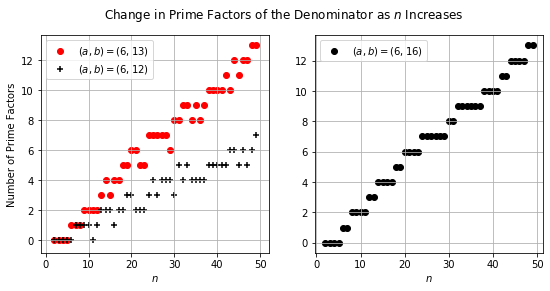

In [194]:
num_factor_list1 = []
test1 = deg_2_case(6,13,50)
for n in range(2,50):
    amount = len(denom_prime_factor_tuple(test1,n))
    num_factor_list1.append((n,amount))
x1 = [coord[0] for coord in num_factor_list1]
y1 = [coord[1] for coord in num_factor_list1]


num_factor_list2 = []
test2 = deg_2_case(6,12,50)
for n in range(2,50):
    amount = len(denom_prime_factor_tuple(test2,n))
    num_factor_list2.append((n,amount))
x2 = [coord[0] for coord in num_factor_list2]
y2 = [coord[1] for coord in num_factor_list2]

num_factor_list3 = []
test3 = deg_2_case(1,3,50)
for n in range(2,50):
    amount = len(denom_prime_factor_tuple(test3,n))
    num_factor_list3.append((n,amount))
x3 = [coord[0] for coord in num_factor_list3]
y3 = [coord[1] for coord in num_factor_list3]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,4))
fig.suptitle('Change in Prime Factors of the Denominator as $n$ Increases')
ax1.scatter(x1,y1,c='red',label = '$(a,b) = (6,13)$')
ax1.scatter(x2,y2,marker = '+', c='black', label = '$(a,b) = (6,12)$')
ax1.grid()
ax1.legend()
ax1.set_xlabel('$n$')
ax1.set_ylabel('Number of Prime Factors')
ax2.scatter(x3,y3,c = 'black', label = '$(a,b) = (6,16)$')
ax2.grid()
ax2.legend()
ax2.set_xlabel('$n$')
plt.show()